# *Содержание* 
- [Подключение к API](#Подключение-к-API-VK)
-[Выборка и ее обснование с проверкой](#Обоснование-выборки-и-проверка)
- [Выгрузка данных](#Выгрузка-данных-с-3-групп)
- [Обработка данных](#Обработка-и-чистка-датафрейма)
    * [Удаление нерепрезентативных пропусков](#Удаление-пустых-значений-по-столбцам)
        * [Столбец ID](#ID)
        * [Столбец City](#City)
        * [Столбец Country](#Country)
        * [Столбец University](#University)
        * [Столбец Bdate](#Bdate)
        * [Столбец Deactivated](#Deactivated)
    * [Привод значений к единому виду](#Приведение-данных-к-единому-виду)
        * [Столбец sex](#sex)
        * [Столбец Country](#Country)
        * [Столбец Is_closed](#Is_closed)
        * [Столбец B_year](#B_year)
- [Анализ и визуализация](#Анализ-и-визуализация)
    * [Подсчет значений](#Подсчеты)
    * [Создание сводных таблиц](#Таблицы)
    * [Построение графиков](#Графики)

# Подключение к API VK

In [1]:
import datetime                 
import pickle                    
import requests                  
import pandas as pd              
import numpy as np               
import matplotlib.pyplot as plt  
import time            
        

from tqdm import tqdm_notebook   

In [2]:
pip install flatten_json

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
# мой номер странички
my_user_id = 369353732
# версия используемого API
version = '5.103' 
# подгружаем токен
with open('markeraccess.txt') as f:
    token = f.read()

In [10]:
url = "https://api.vk.com/method/users.get?user_ids={user_id}&access_token={token}&v={version}"
url = url.format(user_id=my_user_id, token=token, version=version)

In [12]:
# проверяю соединение
response = requests.get(url) 
response

<Response [200]>

# Обоснование выборки и проверка

In [6]:
# Создаю словарь с официальными игровыми пабликами ВК и их тегами. Выборка обусловленна: 1- наличием официальной группы, 2- предположительно разновозрастной целевой аудиторией 3- количество подписчиков больше 5 тысяч.  
game_groups = {
    'Тарков' : 'tarkovarena',
    'Дестени' : 'destinythegame',
    'Бравлстарс' : 'brawl_stars'
}

In [191]:
# Функция для выгрузки ID всех пользователей определенного паблика

def getGroupMembers(group_id): 
    # подсчет необходимого числа запросов
    count = vkDownload('groups.getMembers','group_id=' + group_id)['response']['count']
    n = int(np.ceil(count/1000))  
    # вектор для хранения id пользователей
    members = []     
    
    for i in tqdm_notebook(range(n)): 
        current_members = vkDownload('groups.getMembers','group_id='+group_id+'&offset='+str(1000*i))
        members.extend(current_members['response']['items'])
        time.sleep(0.4)
        
    return members

In [178]:
# Выгружаю Id для группы по Destiny 2
Destiny_members = getGroupMembers(game_groups['Дестени'])

C:\Users\HP\AppData\Local\Temp\ipykernel_28332\1341403498.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/41 [00:00<?, ?it/s]

In [206]:
# Выгружаю Id для группы по Tarkov Arena (почему-то тег официальной группы по просто "Esacpe from Tarkov" не работал, выдавалась ошибка в response)
tarkov_members = getGroupMembers(game_groups['Тарков'])

C:\Users\HP\AppData\Local\Temp\ipykernel_28332\1341403498.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/54 [00:00<?, ?it/s]

In [210]:
# Выгружаю Id для группы по Brawl Stars
brawlstars_members = getGroupMembers(game_groups['Бравлстарс'])

C:\Users\HP\AppData\Local\Temp\ipykernel_28332\1341403498.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/666 [00:00<?, ?it/s]

In [194]:
# Проверяю количество выгруженных ID для 1 паблика
len(Destiny_members)

40617

In [208]:
# Проверяю количество выгруженных ID для 2 паблика
len(tarkov_members)

53883

In [211]:
# Проверяю количество выгруженных ID для 3 паблика
len(brawlstars_members)

665204

<font color=purple> Все работает, теперь можно сделать цикл и поместить ID подписчиков всех 3 групп в один словарь

# Выгрузка данных с 3 групп

In [269]:
# Цикл для выгрузки всех участников групп
# Выкачиваею членов каждой группы 

game_susbs = {}
for game, group_id in game_groups.items():
    game_susbs[game] = getGroupMembers(group_id)


C:\Users\HP\AppData\Local\Temp\ipykernel_28332\1341403498.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n)):


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/666 [00:00<?, ?it/s]

In [270]:
# Проверяю количество выгруженных ID для всех трех пабликов
for game, people in game_susbs.items():
    print("Игровой паблик: {}, число подписчиков: {}".format(game, len(people)))

Игровой паблик: Тарков, число подписчиков: 53883
Игровой паблик: Дестени, число подписчиков: 40616
Игровой паблик: Бравлстарс, число подписчиков: 665203


In [271]:
# Прописываю параметры в соответствии справочником API для VK. Также, на всякий случай, указываю ID каждой из групп. 
fields = 'bdate, country, city, sex, education'
grp1_id = '-89771130'
grp2_id = '-167609719'
grp3_id = '-138011123'

In [277]:
# Функция для подгрузки социально-демографических данных по подписчикам групп в один словарь.

def getUserInformation():
    
    # инициализируем пустой словарь, где будут хранитсья пользователи с их соцдемом
    subs_information = {}
    # проходимся по всем кандидатам
    for game, people in game_susbs.items():
        # текущий список пользователей с соц-демом
        current_info = []
        
        # В range указываю ограничение в 10, чтобы не скачивать информацию по сотням тысяч пользователей, а ограничиться выборкой в 15 000
        for i in tqdm_notebook(range(10)):
            # берем текущий срез подписчиков
            ids = people[i*500:(i+1)*500]
            ids = ','.join([str(user) for user in ids])
            # выгружаем их и берем данные
            info = vkDownload('users.get','user_ids={}&fields={}'.format(ids, fields))
            info = info['response']
            # записываем в текущий лист
            current_info.extend(info)
            # ждем перед следующим запросом
            time.sleep(0.4)
        
        # записываем в финальный словарь
        subs_information[game] = current_info
    
    return subs_information

In [278]:
# Инициирую выгрузку
subs_information = getUserInformation()

C:\Users\HP\AppData\Local\Temp\ipykernel_28332\1716350400.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [288]:
# Перевожу словарь в датафрейм, для чего сначала создаю пустой датафрейм.
subs_df = pd.DataFrame()

# цикл по всем игровым пабликам и соц-дему их подписчиков
for game, people in subs_information.items():
    # преобразую словарь в датафрейм
    df = pd.DataFrame(people)
    # добавляю столбец с городом
    df['city'] = df.city.apply(lambda x: x['title'] if x is not np.nan else np.nan)
    # добавляю столбец с названием игры (паблика ВК)
    df['game'] = game
    # добавляем преобразованный датафрейм к финальному
    subs_df = subs_df.append(df, ignore_index=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_28332\2377014620.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subs_df = subs_df.append(df, ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_28332\2377014620.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subs_df = subs_df.append(df, ignore_index=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_28332\2377014620.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  subs_df = subs_df.append(df, ignore_index=True)


In [294]:
# Выкачиваю получившийся датафрейм в таблицу csv, чтобы при перезахде в python не пришлось заново повторять все предыдущие действия.
subs_df.to_csv('test_subs_pd.csv', sep=',')

In [26]:
# После перезахода обратно загружаю таблицу csv в датафрейм pandas.
subs_df = pd.read_csv('test_subs_pd.csv')

In [18]:
# Проверяю, что все отображается корректно.
subs_df

,Unnamed: 0,id,bdate,city,country,university,university_name,faculty,faculty_name,graduation,education_form,education_status,sex,first_name,last_name,can_access_closed,is_closed,deactivated,game
0,0,3744,10.5,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",1.0,СПбГУ,7.0,Математико-механический,2012.0,Очное отделение,Выпускник (специалист),2,Alexander,Ageyev,True,False,NaN,Тарков
1,1,5217,29.7,Москва,"{'id': 1, 'title': 'Россия'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Никита,Красиков,True,False,NaN,Тарков
2,2,7241,24.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Денис,Игоревич,False,True,NaN,Тарков
3,3,8315,19.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Иван,Ли,False,True,NaN,Тарков
4,4,8404,6.6.1987,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",68.0,СПбГЭТУ «ЛЭТИ»,324.0,"Компьютерных технологий и информатики (ФКТИ, Ф...",2008.0,Очное отделение,Выпускник (бакалавр),2,Александр,Петров,True,False,NaN,Тарков
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,91226047,6.10.2000,Strasbourg,"{'id': 209, 'title': 'Франция'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Тамерлан,Калимуллин,True,False,NaN,Бравлстарс
14996,14996,91244863,6.11,NaN,"{'id': 1, 'title': 'Россия'}",92.0,РАНХиГС при Президенте РФ (бывш. АНХ при Прави...,2124890.0,Институт менеджмента и маркетинга,0.0,NaN,NaN,2,Карим,Масков,True,False,NaN,Бравлстарс
14997,14997,91247242,21.9.1989,Минск,"{'id': 3, 'title': 'Беларусь'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Алексей,Muchkin,True,False,NaN,Бравлстарс
14998,14998,91257531,10.1,NaN,"{'id': 1, 'title': 'Россия'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Ян,Кантимиров,True,False,NaN,Бравлстарс


# Обработка и чистка датафрейма

<font color=purple> В датафрейме получилось слишком много столбцов, и многие из них не содержат ценной инормации. 
Так, например, "can_access_closed" и "is_closed" по факту обозначают одно и тоже, просто обратными значениямм.
Столбцы, полученные из field==education кажутся во многом слишком подробными, поэтому можно ограничится только названием университета.
"Столбец Unnamed: 0" дублирует индексирование, что тоже мне не кажется необходимым.

In [28]:
# Удаляю лишние столбцы по их индексам
subs_df = subs_df.drop(subs_df.columns[[0,5,7,8,9,10,11,15]], axis= 1)

In [81]:
# Для упрощения навигации перезаписываю датафрейм с удаленными столбцами в другой.
subsd_df = subs_df
subsd_df

,id,bdate,city,country,university_name,sex,first_name,last_name,is_closed,deactivated,game
0,3744,10.5,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",СПбГУ,2,Alexander,Ageyev,False,NaN,Тарков
1,5217,29.7,Москва,"{'id': 1, 'title': 'Россия'}",NaN,2,Никита,Красиков,False,NaN,Тарков
2,7241,24.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,2,Денис,Игоревич,True,NaN,Тарков
3,8315,19.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,2,Иван,Ли,True,NaN,Тарков
4,8404,6.6.1987,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",СПбГЭТУ «ЛЭТИ»,2,Александр,Петров,False,NaN,Тарков
...,...,...,...,...,...,...,...,...,...,...,...
14995,91226047,6.10.2000,Strasbourg,"{'id': 209, 'title': 'Франция'}",NaN,2,Тамерлан,Калимуллин,False,NaN,Бравлстарс
14996,91244863,6.11,NaN,"{'id': 1, 'title': 'Россия'}",РАНХиГС при Президенте РФ (бывш. АНХ при Прави...,2,Карим,Масков,False,NaN,Бравлстарс
14997,91247242,21.9.1989,Минск,"{'id': 3, 'title': 'Беларусь'}",NaN,2,Алексей,Muchkin,False,NaN,Бравлстарс
14998,91257531,10.1,NaN,"{'id': 1, 'title': 'Россия'}",NaN,1,Ян,Кантимиров,False,NaN,Бравлстарс


## Удаление пустых значений по столбцам

### ID

In [82]:
# Проверяю наличие дубликватов по id, которое могло получится при выгрузке данных
subsd_df['id'].nunique()
# Получаю 91 повторяющиеся значения, но, перед удалением, проверю из-за чего они возникли. 

14909

In [83]:
# Нахожу конкретне повторяющиеся id 
subsd_df['id'].value_counts()

15862638    3
28597822    2
13456986    2
33479267    2
2207470     2
           ..
75773       1
84796       1
87445       1
88435       1
91273620    1
Name: id, Length: 14909, dtype: int64

In [84]:
# Смотрю на содержание этих id
subsd_df[subsd_df['id']==15862638]

,id,bdate,city,country,university_name,sex,first_name,last_name,is_closed,deactivated,game
2679,15862638,12.6,Волгоград,"{'id': 1, 'title': 'Россия'}",NaN,1,Вероника,Трушковская,True,NaN,Тарков
7543,15862638,12.6,Волгоград,"{'id': 1, 'title': 'Россия'}",NaN,1,Вероника,Трушковская,True,NaN,Дестени
11385,15862638,12.6,Волгоград,"{'id': 1, 'title': 'Россия'}",NaN,1,Вероника,Трушковская,True,NaN,Бравлстарс


<font color='purple'> Получается, что повторяющиеся значения - это просто те пользователи, которые зарегистрированны в нескольких исслдеуемых мною группах.
Хоть и игры достаточно сильно отличаются друг от друга по тематической направленности, я не предусмотрел возможность подписки одного человека на несколько групп. Следовательно, удалять эти строки как дубликаты я не буду.

### City

In [85]:
# Проверяю количество пропусков в столбце городов.
subsd_df['city'].isnull().sum()
# Эти строки можно удалить без потери ценной информации.

2503

In [86]:
# Удаляю строки с пропущенными значениями только по столбцу city
subsd_df = subsd_df.dropna(subset=['city'])
# Проверяю, правильно ли все удалилось
subsd_df['city'].isnull().sum()

0

<font color='purple'> Вроде верно, для уверенности посмотрю по количеству всех строк в датафрейме

In [87]:
subsd_df.shape[0]
# Пропуски по city удалены корректно, перехожу на следующие столбцы.

12497

### Country

In [88]:
# Проверяю количество пропусков в столбце страны.
subsd_df['country'].isnull().sum()

394

In [89]:
# Удаляю строки с пропущенными значениями только по столбцу city
subsd_df = subsd_df.dropna(subset=['country'])
# Проверяю, правильно ли все удалилось
subsd_df['country'].isnull().sum()
# В столбце страны больше нет пропусков

0

### Bdate

In [90]:
# Проверяю количество пропусков в столбце даты рождения.
subsd_df['bdate'].isnull().sum()

2405

In [91]:
# Удаляю строки с пропущенными значениями только по столбцу bdate
subsd_df = subsd_df.dropna(subset=['bdate'])
# Проверяю, правильно ли все удалилось
subsd_df['bdate'].isnull().sum()
# В столбце даты рождения больше нет пропусков

0

### University

In [92]:
# Проверяю количество пропусков в столбце названия университета.
subsd_df['university_name'].isnull().sum()

8160

<font color='purple'>Получаю слишком большое количесвто пропусков, при удалении которых мой датафрейм станет слишком малого размера, поэтому оставлю этот столбец на потом.

### Deactivated

In [95]:
# Перед проверкой столбца deactivated нахожу общще количество оставшихся строк
subsd_df.shape[0]

9698

In [96]:
# Проверяю количество пустых значений по столбцу deactivated, которые означают существование и финкционирование аккаунтов.
subsd_df['deactivated'].isnull().sum()
# Получаю, что в столбце deactivated нету не активных пользователей, значит сам столбец можно полностью удалить

9698

In [97]:
# Удалаю столбец deactivated
subsd_df = subsd_df.drop('deactivated', axis= 1)
# Проверяю удаление
subsd_df

,id,bdate,city,country,university_name,sex,first_name,last_name,is_closed,game
0,3744,10.5,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",СПбГУ,2,Alexander,Ageyev,False,Тарков
1,5217,29.7,Москва,"{'id': 1, 'title': 'Россия'}",NaN,2,Никита,Красиков,False,Тарков
2,7241,24.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,2,Денис,Игоревич,True,Тарков
3,8315,19.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,2,Иван,Ли,True,Тарков
4,8404,6.6.1987,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",СПбГЭТУ «ЛЭТИ»,2,Александр,Петров,False,Тарков
...,...,...,...,...,...,...,...,...,...,...
14990,91160706,7.9,Новосибирск,"{'id': 1, 'title': 'Россия'}",NaN,1,Светлана,Фомышина,False,Бравлстарс
14991,91177027,29.1.1974,Красноармейск,"{'id': 1, 'title': 'Россия'}",NaN,2,Сергей,Квардонов,True,Бравлстарс
14994,91225145,18.6.1987,Мурманск,"{'id': 1, 'title': 'Россия'}",NaN,1,Светлана,Нестерова,False,Бравлстарс
14995,91226047,6.10.2000,Strasbourg,"{'id': 209, 'title': 'Франция'}",NaN,2,Тамерлан,Калимуллин,False,Бравлстарс


## Приведение данных к единому виду

### sex

In [104]:
# Создаю для этого этапа новый датасет и сохраняю прошлый в csv
subs_del = subsd_df 
subsd_df.to_csv('subsd_df.csv', sep=',')

In [37]:
subsd_df = pd.read_csv('subsd_df.csv')
subs_del = subsd_df 

In [38]:
# В столбце "пол" привожу значение к более понятному виду
subs_del['sex'] = np.where(subs_del['sex']==1, 'Female', 'Male')
subs_del

,id,bdate,city,country,university_name,sex,first_name,last_name,is_closed,game
0,3744,10.5,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",СПбГУ,Male,Alexander,Ageyev,False,Тарков
1,5217,29.7,Москва,"{'id': 1, 'title': 'Россия'}",NaN,Male,Никита,Красиков,False,Тарков
2,7241,24.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,Male,Денис,Игоревич,True,Тарков
3,8315,19.6,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",NaN,Male,Иван,Ли,True,Тарков
4,8404,6.6.1987,Санкт-Петербург,"{'id': 1, 'title': 'Россия'}",СПбГЭТУ «ЛЭТИ»,Male,Александр,Петров,False,Тарков
...,...,...,...,...,...,...,...,...,...,...
9693,91160706,7.9,Новосибирск,"{'id': 1, 'title': 'Россия'}",NaN,Female,Светлана,Фомышина,False,Бравлстарс
9694,91177027,29.1.1974,Красноармейск,"{'id': 1, 'title': 'Россия'}",NaN,Male,Сергей,Квардонов,True,Бравлстарс
9695,91225145,18.6.1987,Мурманск,"{'id': 1, 'title': 'Россия'}",NaN,Female,Светлана,Нестерова,False,Бравлстарс
9696,91226047,6.10.2000,Strasbourg,"{'id': 209, 'title': 'Франция'}",NaN,Male,Тамерлан,Калимуллин,False,Бравлстарс


### Country

In [39]:
# Столбец country разделяю по знаку ', записываю полученные значения в новые столбцы нового датафрейма
sp = subs_del['country'].str.split("'", expand=True)
# Переименовываю полученные колонки для более удобного индексирования
sp = sp.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: 'country_name', 6: '6'})
# Удаляю ненужные столбцы
sp.drop (sp.columns[[0,1,2,3,4,6]], axis= 1 , inplace= True )
# Проверяю, что получилось
sp

,country_name
0,Россия
1,Россия
2,Россия
3,Россия
4,Россия
...,...
9693,Россия
9694,Россия
9695,Россия
9696,Франция


In [40]:
# Добавляю полученный столбец в исходный датафрейм на 3 позицию (вместо бывшего country)
subs_del.insert (3, 'country_name', sp)
# Удаляю старый столбец country
subs_del=subs_del.drop('country', axis=1)
# Проверяю
subs_del
# Все заменилось успешно

,id,bdate,city,country_name,university_name,sex,first_name,last_name,is_closed,game
0,3744,10.5,Санкт-Петербург,Россия,СПбГУ,Male,Alexander,Ageyev,False,Тарков
1,5217,29.7,Москва,Россия,NaN,Male,Никита,Красиков,False,Тарков
2,7241,24.6,Санкт-Петербург,Россия,NaN,Male,Денис,Игоревич,True,Тарков
3,8315,19.6,Санкт-Петербург,Россия,NaN,Male,Иван,Ли,True,Тарков
4,8404,6.6.1987,Санкт-Петербург,Россия,СПбГЭТУ «ЛЭТИ»,Male,Александр,Петров,False,Тарков
...,...,...,...,...,...,...,...,...,...,...
9693,91160706,7.9,Новосибирск,Россия,NaN,Female,Светлана,Фомышина,False,Бравлстарс
9694,91177027,29.1.1974,Красноармейск,Россия,NaN,Male,Сергей,Квардонов,True,Бравлстарс
9695,91225145,18.6.1987,Мурманск,Россия,NaN,Female,Светлана,Нестерова,False,Бравлстарс
9696,91226047,6.10.2000,Strasbourg,Франция,NaN,Male,Тамерлан,Калимуллин,False,Бравлстарс


### Is_closed

In [41]:
# Корректирую столбец is_closed: переименовываю его в access_type
subs_del.rename(columns={'is_closed' : 'access_type'}, inplace = True)
# Меняю формулировку значений: False на Open, True на Closed
subs_del['access_type'] = subs_del['access_type'].replace(False, 'Open')
subs_del['access_type'] = subs_del['access_type'].replace(True, 'Closed')
# Проверяю
subs_del
# Все заменилось успешно

,id,bdate,city,country_name,university_name,sex,first_name,last_name,access_type,game
0,3744,10.5,Санкт-Петербург,Россия,СПбГУ,Male,Alexander,Ageyev,Open,Тарков
1,5217,29.7,Москва,Россия,NaN,Male,Никита,Красиков,Open,Тарков
2,7241,24.6,Санкт-Петербург,Россия,NaN,Male,Денис,Игоревич,Closed,Тарков
3,8315,19.6,Санкт-Петербург,Россия,NaN,Male,Иван,Ли,Closed,Тарков
4,8404,6.6.1987,Санкт-Петербург,Россия,СПбГЭТУ «ЛЭТИ»,Male,Александр,Петров,Open,Тарков
...,...,...,...,...,...,...,...,...,...,...
9693,91160706,7.9,Новосибирск,Россия,NaN,Female,Светлана,Фомышина,Open,Бравлстарс
9694,91177027,29.1.1974,Красноармейск,Россия,NaN,Male,Сергей,Квардонов,Closed,Бравлстарс
9695,91225145,18.6.1987,Мурманск,Россия,NaN,Female,Светлана,Нестерова,Open,Бравлстарс
9696,91226047,6.10.2000,Strasbourg,Франция,NaN,Male,Тамерлан,Калимуллин,Open,Бравлстарс


### B_year

In [42]:
# Попробую привести значения столбца bdate к о одному виду. Для этого создаю новый датафрейм
subs_bd = subs_del

In [43]:
# В еще один датафрейм записываю результат деления по разделителю '.'
bd = subs_del['bdate'].str.split('.', expand=True)
# Убираю лишние колонки
bd.drop(bd.columns[[0,1]], axis= 1 , inplace= True )
# Переименовываю колонку с годом рождения
bd = bd.rename(columns={0: 'b_year'})
# Добавляю это колонку в датасет
subs_bd.insert (2, 'b_year', bd)
# Проверяю
subs_bd

,id,bdate,b_year,city,country_name,university_name,sex,first_name,last_name,access_type,game
0,3744,10.5,None,Санкт-Петербург,Россия,СПбГУ,Male,Alexander,Ageyev,Open,Тарков
1,5217,29.7,None,Москва,Россия,NaN,Male,Никита,Красиков,Open,Тарков
2,7241,24.6,None,Санкт-Петербург,Россия,NaN,Male,Денис,Игоревич,Closed,Тарков
3,8315,19.6,None,Санкт-Петербург,Россия,NaN,Male,Иван,Ли,Closed,Тарков
4,8404,6.6.1987,1987,Санкт-Петербург,Россия,СПбГЭТУ «ЛЭТИ»,Male,Александр,Петров,Open,Тарков
...,...,...,...,...,...,...,...,...,...,...,...
9693,91160706,7.9,None,Новосибирск,Россия,NaN,Female,Светлана,Фомышина,Open,Бравлстарс
9694,91177027,29.1.1974,1974,Красноармейск,Россия,NaN,Male,Сергей,Квардонов,Closed,Бравлстарс
9695,91225145,18.6.1987,1987,Мурманск,Россия,NaN,Female,Светлана,Нестерова,Open,Бравлстарс
9696,91226047,6.10.2000,2000,Strasbourg,Франция,NaN,Male,Тамерлан,Калимуллин,Open,Бравлстарс


In [44]:
# Смотрю количество пропущенных значений
subs_bd.isnull().sum()

id                    0
bdate                 0
b_year             3984
city                  0
country_name          0
university_name    8160
sex                   0
first_name            0
last_name             0
access_type           0
game                  0
dtype: int64

In [45]:
# Удаляю пропуски
subs_bd = subs_bd.dropna(subset=['b_year'])
# Проверяю
subs_bd.isnull().sum()

id                    0
bdate                 0
b_year                0
city                  0
country_name          0
university_name    4666
sex                   0
first_name            0
last_name             0
access_type           0
game                  0
dtype: int64

In [47]:
# Чтобы вычислить возраст, перевожу значиния стобца b_year из object в int
subs_bd['b_year'] = pd.to_numeric(subs_bd['b_year'], errors= 'coerce')
# Делаю приблизительное вычисление, не учитывающее месяц рождения
subs_bd['age'] = 2024 - subs_bd['b_year']
# Проверяю
subs_bd

C:\Users\HP\AppData\Local\Temp\ipykernel_24192\2735630915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs_bd['b_year'] = pd.to_numeric(subs_bd['b_year'], errors= 'coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_24192\2735630915.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs_bd['age'] = 2024 - subs_bd['b_year']


,id,bdate,b_year,city,country_name,university_name,sex,first_name,last_name,access_type,game,age
4,8404,6.6.1987,1987,Санкт-Петербург,Россия,СПбГЭТУ «ЛЭТИ»,Male,Александр,Петров,Open,Тарков,37
5,11107,4.11.1986,1986,Санкт-Петербург,Россия,NaN,Male,Никита,Буянов,Closed,Тарков,38
6,14345,19.1.1986,1986,Санкт-Петербург,Россия,СПбПУ Петра Великого (Политех),Male,Николай,Дьяченко,Open,Тарков,38
7,23634,28.2.1988,1988,Санкт-Петербург,Россия,NaN,Male,Николай,Песчанский,Open,Тарков,36
8,27679,1.12.1989,1989,Санкт-Петербург,Россия,NaN,Male,Николай,Цыганков,Open,Тарков,35
...,...,...,...,...,...,...,...,...,...,...,...,...
9691,91148937,25.10.1983,1983,Кемерово,Россия,КузГТУ им. Т. Ф. Горбачёва,Male,Николай,Мерзляков,Open,Бравлстарс,41
9694,91177027,29.1.1974,1974,Красноармейск,Россия,NaN,Male,Сергей,Квардонов,Closed,Бравлстарс,50
9695,91225145,18.6.1987,1987,Мурманск,Россия,NaN,Female,Светлана,Нестерова,Open,Бравлстарс,37
9696,91226047,6.10.2000,2000,Strasbourg,Франция,NaN,Male,Тамерлан,Калимуллин,Open,Бравлстарс,24


In [48]:
# Сохраняю результат в таблицу csv
subs_bd.to_csv('subs_f.csv', sep=',')

In [63]:
# После перезахода обратно загружаю таблицу csv в датафрейм pandas.
subs_bd = pd.read_csv('subs_f.csv')
subs_bd = subs_bd.drop(subs_bd.columns[[0]], axis=1)
subs_bd

,id,bdate,b_year,city,country_name,university_name,sex,first_name,last_name,access_type,game,age
0,8404,6.6.1987,1987,Санкт-Петербург,Россия,СПбГЭТУ «ЛЭТИ»,Male,Александр,Петров,Open,Тарков,37
1,11107,4.11.1986,1986,Санкт-Петербург,Россия,NaN,Male,Никита,Буянов,Closed,Тарков,38
2,14345,19.1.1986,1986,Санкт-Петербург,Россия,СПбПУ Петра Великого (Политех),Male,Николай,Дьяченко,Open,Тарков,38
3,23634,28.2.1988,1988,Санкт-Петербург,Россия,NaN,Male,Николай,Песчанский,Open,Тарков,36
4,27679,1.12.1989,1989,Санкт-Петербург,Россия,NaN,Male,Николай,Цыганков,Open,Тарков,35
...,...,...,...,...,...,...,...,...,...,...,...,...
5709,91148937,25.10.1983,1983,Кемерово,Россия,КузГТУ им. Т. Ф. Горбачёва,Male,Николай,Мерзляков,Open,Бравлстарс,41
5710,91177027,29.1.1974,1974,Красноармейск,Россия,NaN,Male,Сергей,Квардонов,Closed,Бравлстарс,50
5711,91225145,18.6.1987,1987,Мурманск,Россия,NaN,Female,Светлана,Нестерова,Open,Бравлстарс,37
5712,91226047,6.10.2000,2000,Strasbourg,Франция,NaN,Male,Тамерлан,Калимуллин,Open,Бравлстарс,24


<font color='purple'> Датасет почищен за исключением столбца university_name, в котором находится слишком малое количество ненулевых значений. Для решения этой проблемы, в теории можно было на этапе выгрузки значительно расширить выборку, чтобы в нее точно набралось как минимум 5 тысяч пользователей, с у казанным университетом. Однако, не у всех пользователей может быть указан университет в силу их возраста, то есть при удалении пустых значений, потерялась бы часть изучаемой аудитории.

# Анализ и визуализация

## Подсчеты

In [93]:
# Смотрю сколько уникальных значений по параметру стран
subs_bd['country_name'].nunique()

51

In [70]:
# Вывожу топ 10 стран по пользователям трех пабликов
subs_bd['country_name'].value_counts().head(10)

Россия       5226
Украина       171
Беларусь      144
Казахстан      37
США            16
Германия       12
Эстония        11
Испания         9
Молдова         8
Кипр            5
Name: country_name, dtype: int64

<font color='purple'> Первые страны в топе довольно предсказуемы, потому что контент Вконтакте как раз предназначен для русскоговорящего и СНГ регионов. Так как в ВК можно без дополнительной проверки указывать в профиле страну, я ожидал, что будет больше стран по типу США. Видимо, далеко не все пользователи пользуются данной возможностью.

In [80]:
# Смотрю сколько уникальных значений по городам
subs_bd['city'].nunique()

809

In [77]:
# Вывожу топ 10 городов по пользователям трех пабликов
subs_bd['city'].value_counts().head(10)

Москва             1100
Санкт-Петербург     702
Екатеринбург        126
Новосибирск         108
Самара               81
Нижний Новгород      80
Казань               76
Красноярск           73
Краснодар            68
Минск                65
Name: city, dtype: int64

<font color='purple'> Примечательно, что расположение первых четырех городов почти польностью коррелирует с численностью их населения (Екатеринбург и Новосибирск должы поменться местами для corr==1) 

In [81]:
# Смотрю количество уникальных значений по университетам
subs_bd['university_name'].nunique()

594

In [92]:
# Вывожу топ 15 по количеству подписчиков из этих университетов
subs_bd['university_name'].value_counts().head(15)

СПбПУ Петра Великого (Политех)                      13
МФПУ «Синергия» (бывш. МФПА, ММИЭИФП)               11
МАИ                                                 10
МГУ                                                 10
МГТУ им. Н. Э. Баумана (бывш. МВТУ)                  8
РУТ (МИИТ) (бывш. МГУПС Императора Николая II)       8
СПбГУ                                                8
УдГУ                                                 7
ГУАП                                                 7
СПбГЭУ                                               7
ИжГТУ им. М. Т. Калашникова (бывш. ИМИ)              7
РГПУ им. А. И. Герцена                               7
ТюмГНГУ                                              6
УрФУ им. первого Президента России Б. Н. Ельцина     6
ТюмГУ                                                6
Name: university_name, dtype: int64

<font color='purple'> Интересно, что в топе немного самых крупных вузов страны, что возможно связано со среднем возрастом подписчиков (будет проюллюстрированно далее). То есть, примерно 18 лет назад популярность и масштабность вузов страны значительно отличались от сегодняшней ситуации.

In [96]:
# Смотрю количество закрытых и открытых профилей
subs_bd['access_type'].value_counts()

Open      4411
Closed    1303
Name: access_type, dtype: int64

<font color='purple'> Я ожидал, что если и между открытыми и закрытыми профилями не будет примерно равного соотношения, то, основываясь на опыте пользования Вконтакте, вероятнее, что закрытых профилей будет больше. Но цифры говорят об обратном. Это можно объяснить: 1 - тем, что ограничения доступа к профилю - это относительно недавняя функция, 2 - тем, что среди более взрослых пользователей такая функция пользуется меньшим спросом, чем среди младших подписчиков.

## Таблицы

In [76]:
# Получаю медианный год рождения подписчиков для каждой игры
subs_bd.groupby('game')['b_year'].median()

game
Бравлстарс    1988.0
Дестени       1990.0
Тарков        1990.0
Name: b_year, dtype: float64

In [64]:
# Получаю медианный возраст подписчиков для каждой игры
subs_bd.groupby('game')['age'].median().sort_values(ascending=False)

game
Бравлстарс    36.0
Дестени       34.0
Тарков        34.0
Name: age, dtype: float64

<font color='purple'> Две предыдущие таблицы хоть и репрезентируют одно и тоже, но результаты от этого не становяться менее удивительными. Не только средней возраст подписчиков паблликов про современные видеоигры оказался равен примерно 35 годам, но и игра brawlstars, которая значительно других нацелена на младшую аудиторию, имеет наибольшый медианный возраст подписчика. Возможно, такое смещение произошло при скачке данных, во время которой брались id тех пользователей, которые первые подписались на определенный паблик. А поскольку паблики существуют на протяжении нескольких лет (кроме Таркова), к ним, возможно, сначала присоединялись более взрослые пользователи.
    
<font color='purple'> Есть еще шанс того, что подписчики выставляли ненастоящий свой возраст, но, по идее, количество данных в выборке должно было нивелировать такое смещение.

In [65]:
# Получаю медианный возраст подписчиков по полу
subs_bd.groupby('sex')['age'].median().sort_values(ascending=False)
# Разичие хоть и небольшое, но медианный возраст подписчиц оказался выше

sex
Female    36.0
Male      34.0
Name: age, dtype: float64

In [66]:
# Получаю количество подписчиков по полу и игре
subs_bd.groupby(['sex', 'game'])['id'].count().sort_values(ascending=False)

sex     game      
Male    Тарков        2011
        Дестени       1845
        Бравлстарс    1072
Female  Бравлстарс     639
        Дестени        111
        Тарков          36
Name: id, dtype: int64

In [67]:
# Получаю количество подписчиков по типу аккаунта и игре
subs_bd.groupby(['access_type', 'game'])['id'].count().sort_values(ascending=False)

access_type  game      
Open         Тарков        1701
             Дестени       1485
             Бравлстарс    1225
Closed       Бравлстарс     486
             Дестени        471
             Тарков         346
Name: id, dtype: int64

In [79]:
# Получаю количество подписчиков по городу и игре
subs_bd.groupby(['city', 'game'])['id'].count().sort_values(ascending=False).head(7)

city             game      
Москва           Дестени       456
                 Тарков        408
Санкт-Петербург  Дестени       261
                 Тарков        253
Москва           Бравлстарс    236
Санкт-Петербург  Бравлстарс    188
Екатеринбург     Тарков         52
Name: id, dtype: int64

In [95]:
subs_bd.corr()

,id,b_year,age
id,1.000000,0.079549,-0.079549
b_year,0.079549,1.000000,-1.000000
age,-0.079549,-1.000000,1.000000


## Графики

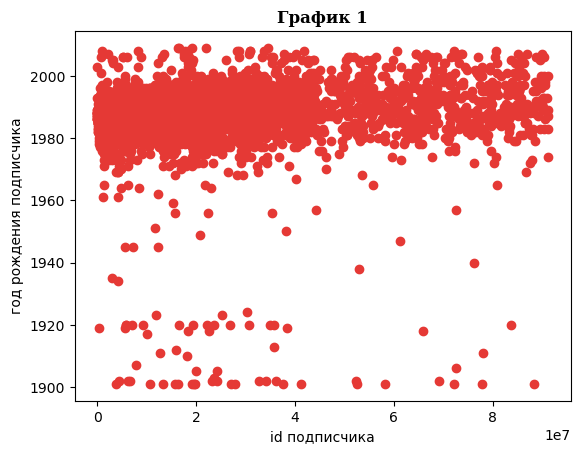

In [97]:
plt.title("График 1", fontweight='bold', family= 'serif')
plt.xlabel("id подписчика")
plt.ylabel("год рождения подписчика")
plt.scatter(subs_bd["id"], subs_bd["b_year"], color = "#e53935")

<AxesSubplot:title={'center':'Выбросы среди возрастов'}, xlabel='Количество id'>

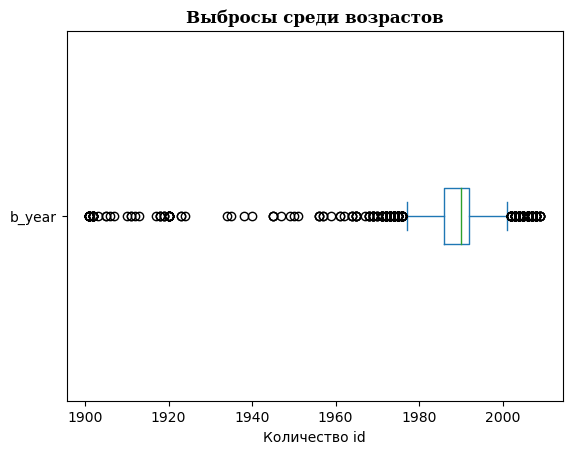

In [103]:
plt.title("Выбросы среди возрастов", fontweight='bold', family= 'serif')
plt.xlabel("Количество id")
subs_bd['b_year'].plot(kind = "box", vert=False)

In [100]:
subs_bd[subs_bd['b_year']==1901]

,id,bdate,b_year,city,country_name,university_name,sex,first_name,last_name,access_type,game,age
329,3864002,17.1.1901,1901,Москва,Россия,NaN,Male,Вадим,Малькевич,Closed,Тарков,123
809,10569822,16.8.1901,1901,Новокуйбышевск,Россия,СГАУ им. С. П. Королева,Male,Антон,Брагин,Open,Тарков,123
974,13378739,1.1.1901,1901,Москва,Россия,NaN,Male,Максим,Indefinite,Closed,Тарков,123
1138,15742339,1.1.1901,1901,Томск,Россия,NaN,Male,Klassik,Владислав,Open,Тарков,123
1171,16298917,22.7.1901,1901,Москва,Россия,NaN,Male,Олег,Шишов,Closed,Тарков,123
1333,19241999,19.7.1901,1901,Xai-Xai,Мозамбик,NaN,Male,Игорь,Рудаков,Open,Тарков,123
1358,19702477,28.11.1901,1901,Альметьевск,Россия,NaN,Male,Алексей,Солунов,Open,Тарков,123
3256,19470500,10.8.1901,1901,Москва,Россия,NaN,Male,Антон,Фёдоров,Open,Дестени,123
3531,27079658,28.9.1901,1901,Barcelona,Испания,NaN,Male,Никита,Лобанов,Closed,Дестени,123
3564,27826603,12.2.1901,1901,Санкт-Петербург,Россия,NaN,Male,Алексей,Кочуковский,Open,Дестени,123
